In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pylab as plt
%matplotlib inline

import time
import os

from audioDataLoader.mulaw import mu_law_encode, mu_law_decode
from audioDataLoader.audio_dataset import AudioDatasetConfig, MuLawAudioDataset2
from torch.utils.data import DataLoader

import model.gru_audio_model

### Data Params  
<a id="dataparams"></a>

These parameters are pickled to file, and serve several purposes:
* The allow other programs to properly evaluate and visualize the trained (and also saved) models,
* PRovide a record of the parameters that allow reproducing results. 

In [2]:
resume_checkpoint="./output/20250805_162729/"
sourcedatadir='./data/nsynth.64.76.dl_new'

params = dict(
    # Read/write directory of data & parameter files
    #*************************************
    sample_rate=16000,
    runTimeStamp='{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now()),
    
    datadir = sourcedatadir,
    paramdir = sourcedatadir,

    savemodel = True,
    savemodel_interval = 10, #in units of epochs
    savemodeldir = os.getcwd() + '/output', #default saving directory for models and the parameterization
    
    batches_per_epoch = 10, #1000,  #10000, #max number batches of steps per epoch (typically num_epochs=1)
    batch_size = 256, #256,
    num_epochs = 10,

    # Training parameters
    #*************************************
    noise=.1,
    seqLen = 256, 
    stride = 1,
    
    lr = 0.005,
    props=['instID','amplitude','midiPitch'],
    
    # Model parameters
    hiddenSize = 48, #100,
    nLayers = 4,

)

### Run Params 

In [3]:

sr = params['sample_rate']

batches_per_epoch = params['batches_per_epoch'] #batches per eposh

log_interval = 50
visualize_interval = 100

#Generation parameters
#*************************************
max_length = params['seqLen']*3

# Cuda
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
params

{'sample_rate': 16000,
 'runTimeStamp': '2025-08-05_16-33-01',
 'datadir': './data/nsynth.64.76.dl_new',
 'paramdir': './data/nsynth.64.76.dl_new',
 'savemodel': True,
 'savemodel_interval': 10,
 'savemodeldir': '/home/lonce/working/RNNControl2/output',
 'batches_per_epoch': 10,
 'batch_size': 256,
 'num_epochs': 10,
 'noise': 0.1,
 'seqLen': 256,
 'stride': 1,
 'lr': 0.005,
 'props': ['instID', 'amplitude', 'midiPitch'],
 'hiddenSize': 48,
 'nLayers': 4}

In [4]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def inputcoding(samp) :
    return mu_law_encode(np.array(samp))/255.

def index2float(topi) :
    return(mu_law_decode(topi[0][0]).cpu().numpy())


In [5]:

#--- model settings ----#
model_config = model.gru_audio_model.GRUAudioConfig (
    input_size = 1,
    cond_size = len(params['props']),
    hidden_size = params['hiddenSize'],
    num_layers = params['nLayers'],
    output_size = 256,  #mu-law quantization levels
    dropout = 0.1
)

# ---- Training Settings ----
data_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
   add_noise= False if params['noise'] == 0 else True,   # Whether to add white noise
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=True
)

# ---- Generation Settings ----
testdata_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
   add_noise= False,                        # no noise for testing and priming
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=False
)

# === Dataset and Loader ===
adataset = MuLawAudioDataset2(data_config)
train_loader = DataLoader(adataset,
                             batch_size=params['batch_size'],
                             shuffle=True,
                             num_workers=4,
                             drop_last=True)

testdataset = MuLawAudioDataset2(testdata_config)
test_loader = DataLoader(testdataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=4,
                            drop_last=True)
   

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

size of dataset is 10333440
no. of batches per epoch is 10
batchsize id  is 256


In [6]:
# ---- Create Output Folders ----
if resume_checkpoint != None:
    out_dir = resume_checkpoint
else:
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join(params['savemodeldir'], run_timestamp)
    os.makedirs(out_dir, exist_ok=True)

    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(f"{out_dir}/checkpoints", exist_ok=True)
    os.makedirs(f"{out_dir}/tensorboard", exist_ok=True)


# ---- Save Config ----
#machine readable
torch.save({
    "model_config": model_config,
    "data_config": data_config
}, f"{out_dir}/config.pt")

#human readable
with open(f"{out_dir}/config.txt", "w") as f:
    f.write("model_config = " + repr(model_config) + "\\n")
    f.write("data_config = " + repr(data_config) + "\\n")

size of dataset is 10333440
no. of batches per epoch is 10
batchsize id  is 256
rand_sample: idx=4076709
rand_sample: file_idx=102
rand_sample: start_pos=22821, end_pos=23078
torch.Size([257])


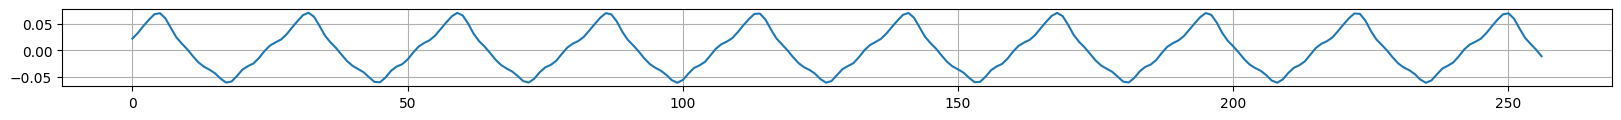

/tmp/ipykernel_458230/3278478625.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return mu_law_encode(np.array(samp))/255.


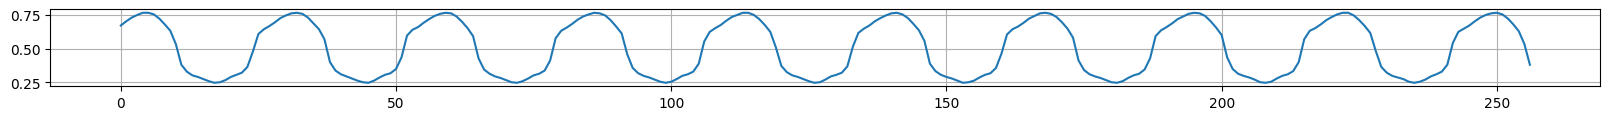

Do it! 2025-08-05 16:33:02
bat num 0 at time 2025-08-05 16:33:03
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
bat num 1 at time 2025-08-05 16:33:03
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
finished at 2025-08-05 16:33:03


In [7]:
# show stuff

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = inputcoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()


n_batches = 1
print("Do it! {}".format(mydate()))
for bat, (x_audio_seq, y_target_seq) in enumerate(test_loader):
    print("bat num {} at time {}".format(bat, mydate()))
    print(f"x_audio_seq.shape = {x_audio_seq.shape}") 
    print(f"y_target_seq.shape = {y_target_seq.shape}")
    if bat >= n_batches :
        break;
print("finished at {}".format(mydate()))

# print(f"x_audio_seq[0,:,0] seq is {x_audio_seq[0,:,0]}")
# print(f"x_audio_seq[0,:,1] seq is {x_audio_seq[0,:,1]}")
# print(f"x_audio_seq[0,:,2] seq is {x_audio_seq[0,:,2]}")
# print(f"x_audio_seq[0,:,3] seq is {x_audio_seq[0,:,3]}")
# print(f"y_target_seq[0,:] seq is {y_target_seq[0,:].squeeze(-1)}")


In [8]:
 # Define the training cycle (100% teacher forcing for now)
 #*************************************
 
 def train(model,epoch):
 
 
     model.train() #put in training mode
     ave_loss_over_steps = 0
 
     debug_seqs=0
 
     for batch_num, (inp, target) in enumerate(train_loader):
 
         if batch_num==0:
             print(f"train() - inp[:,:,0] - Min: {torch.min(inp[:,:,0])}, Max: {torch.max(inp[:,:,0])}, Average: {torch.mean(inp[:,:,0])}")
 
 
         debug_seqs=debug_seqs+len(x_audio_seq) # summing the batch length for each batch_num
 
         inp, target = inp.to(device), target.to(device)
         # Forward + Backward + Optimize
         hidden = model.init_hidden(params['batch_size'])
         optimizer.zero_grad()
         loss = 0
 
         #print(f" inp[0,127,0] (B,T,p) is {inp[0,127,0]}")
 
         # iterate through the SEQUENCE
         for i in range(params['seqLen']):
             outputs, hidden = model(inp[:,i,:],hidden,params['batch_size'])  #input dim: (batch, seq, feature)
             loss += criterion(outputs, torch.squeeze(target[:,i],1))
             #print(f"timestep {i} target is {torch.squeeze(target[:,i],1)}")
 
         loss.backward()
         optimizer.step()
 
         ave_loss_per_sample = loss.item()/params['seqLen']   #over each minibatch
         ave_loss_over_steps += ave_loss_per_sample
 
         if (batch_num+1) % log_interval == 0:
             print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], batch_num [{}/{}] Loss: {:.4f}'.format(
                 datetime.now(), epoch+1, params['num_epochs'], batch_num+1, params['batches_per_epoch'], ave_loss_over_steps/log_interval))
 
             list_of_losses.append(ave_loss_over_steps/log_interval)
             writer.add_scalar("Loss/train", ave_loss_per_sample, epoch)
             ave_loss_over_steps = 0
 
 
         if (batch_num+1) % visualize_interval == 0:
             result = generate(model,max_length)
             plt.figure(figsize=(20,1))
             plt.plot(np.arange(len(result)), result) #just print one example from the batch
             plt.show()
             model.train() #put model back to training mode
 
 
         if batch_num>=(batches_per_epoch-1):
             break
 
     print(f"Finished epoch number {epoch} with a total of {debug_seqs} debug_seqs")
     
     if (epoch + 1) % params['savemodel_interval'] == 0:
         torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, checkpoint_path)
         print(f"Saved checkpoint at epoch {epoch+1}")
 
 
 # generate
 #*************************************
 def generate(model,max_length,primer=None,paramvect=None, returnHiddenSequence=False):
     """Generate a signal using the provided model.
     @param max_length of the synthesized signal
     @param primer a torch.tensor of shape (batch=1, primer_signal=primer_length, num_inputs=1+num_cond_parameters)
     @paramvect conditioning parameters  (a function of i, sample number)
     """ 
     if returnHiddenSequence :
         hs=[]
 
     model.eval()
     with torch.no_grad():
 
         for p_inp, target in test_loader:
 
             print(f"generate() - p_inp_inp[:,:,0] - Min: {torch.min(p_inp[:,:,0])}, Max: {torch.max(p_inp[:,:,0])}, Average: {torch.mean(p_inp[:,:,0])}")
 
             if primer is not None:
                 # must clone else primer is changed outside this function
                 p_inp.data=primer.clone()
             print(f"p_inp = {p_inp}")
             seq = np.copy(p_inp[0,:,0])  #extract the original sample
 
             seq_mu = inputcoding(seq)  #mu-law
 
             p_inp[0,:,0] = torch.from_numpy(seq_mu).float() #now we have both the original and mu-lawed samples
             break
         generated = seq # before mu-law audio encoding
 
         p_inp = p_inp.to(device)
         #print("p_inp",p_inp)
 
         hidden = model.init_hidden()
         if returnHiddenSequence :
             hs.append(torch.squeeze(hidden).cpu().numpy())
 
         print(f"---AND the p_inp we will use to build hidden is {p_inp[0,0:10,:]}")
         for j in range(params['seqLen']-1):  #build up hidden state
             _, hidden = model(p_inp[:,j,:],hidden)
         inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
 
         #print("last inp from primer",inp)
 
         for i in range(max_length):
             outputs, hidden = model(inp,hidden)
 
             outputs = nn.functional.log_softmax(outputs,dim=1)
             topv, topi = outputs.detach().topk(1)  #choose the strongest activation
             #print(topv,topv.shape)
             predicted_sample = index2float(topi)
 
             generated = np.append(generated,predicted_sample)
 
             inp[:,0] = torch.from_numpy(inputcoding([predicted_sample])).type(torch.cuda.FloatTensor)
             #print("input",inp)
             #print("shape",inp.shape)
             if paramvect is not None:
                 inp[:,1:] = torch.tensor(paramvect(i))
                 #print("input2",inp)
 
             if returnHiddenSequence :
                 hs.append(torch.squeeze(hidden).cpu().numpy())
 
         if returnHiddenSequence :
             return generated, hs
         else :
             return generated


<a href="#dataparams">Go To Data Params</a>

In [9]:

rnn = model.gru_audio_model.RNN(model_config).to(device)
    
optimizer = torch.optim.Adam(rnn.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

start_epoch=0
checkpoint_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
if resume_checkpoint:
    assert os.path.exists(checkpoint_path), f"File {checkpoint_path} does not exist"
    checkpoint = torch.load(checkpoint_path)
    rnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from checkpoint at epoch {start_epoch}")

writer = SummaryWriter(log_dir=f"{out_dir}/tensorboard")

Resumed from checkpoint at epoch 10


In [10]:
num_trainable_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_trainable_params}")

Trainable parameters: 69232


In [11]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(start_epoch, start_epoch+params['num_epochs']):
    train(rnn,epoch)
writer.close()
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))


torch.save({
            'epoch': epoch,
            'model_state_dict': rnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)
print(f"Saved checkpoint at epoch {epoch+1}")

2025-08-05 16:33:03 Starting training...
train() - inp[:,:,0] - Min: 0.09019608050584793, Max: 0.9529411792755127, Average: 0.4913994073867798
Finished epoch number 10 with a total of 10 debug_seqs
train() - inp[:,:,0] - Min: 0.0784313753247261, Max: 0.9607843160629272, Average: 0.4929734468460083
Finished epoch number 11 with a total of 10 debug_seqs
train() - inp[:,:,0] - Min: 0.07450980693101883, Max: 0.9803921580314636, Average: 0.4939571022987366
Finished epoch number 12 with a total of 10 debug_seqs
train() - inp[:,:,0] - Min: 0.08627451211214066, Max: 0.95686274766922, Average: 0.49180838465690613
Finished epoch number 13 with a total of 10 debug_seqs
train() - inp[:,:,0] - Min: 0.07450980693101883, Max: 0.9647058844566345, Average: 0.49307358264923096
Finished epoch number 14 with a total of 10 debug_seqs
train() - inp[:,:,0] - Min: 0.07450980693101883, Max: 0.9529411792755127, Average: 0.4923948049545288
Finished epoch number 15 with a total of 10 debug_seqs
train() - inp[:,:,

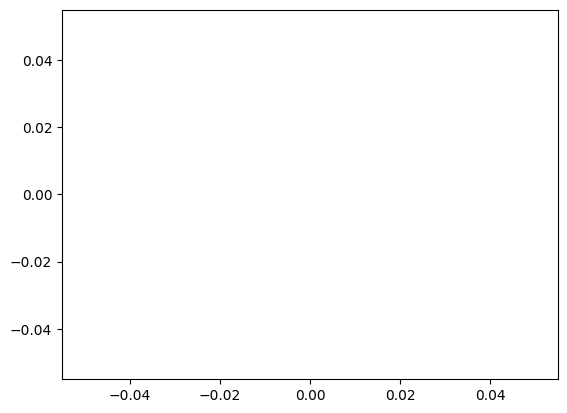

In [12]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)
plt.show()  # This will actually display the plot

In [13]:
foo=[[0.20784315]]
foo[0][0]

0.20784315

In [14]:
list_of_losses

[]